In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost, XGBoost, Target Encoding all Feeatures:: Vary hierarchy (start point)
No blending of hierarchy, just target encode all of the NAICS hierarchy features (separately).  Vary hierarcy, using NAICS + hierarcy above a certain level.

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_blender
# Hierarchical encoder on one feature is just regular target encoding
from sba_gnn.sba_gnn.sg_blender import HierarchicalEncoder 

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

In [7]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

In [8]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

##### Comparison metrics

In [9]:
# Group counts
naics_grp_counts = pd.read_csv(Path(setup.parent_path).joinpath('02_REPORT_naics_grp_stats_all.csv')) \
    [['level_0', 'count_grp']] \
    .drop_duplicates() \
    .set_axis(['naics_type', 'k'], axis=1)

##### Comparison metrics

In [10]:
# Hierarchical encoding, lambda_k = 100
metrics_base = pd.read_csv(Path(setup.parent_path).joinpath('X12_REPORT_metrics.csv'))

In [11]:
# Regular, non-hierarchical target encoding, for a horizontal reference line
metrics_tenc = pd.read_csv(Path(setup.parent_path).joinpath('14_REPORT_metrics.csv'))

In [12]:
# Target+Count
metrics_tc = pd.read_csv(Path(setup.temp_path).joinpath('A06_REPORT_metrics.csv'))

In [13]:
# Target-Thresh
metrics_tt = pd.read_csv(Path(setup.temp_path).joinpath('A13_REPORT_metrics.csv'))

## Function to get metrics

In [14]:
def get_metrics(data, lambda_k = setup.selected_lambda_k, 
                enc_features = ['NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector']):
    
    # Alternative encoding
    train_df = data[data['dset'] == 'train']
    enc_dict = {f:HierarchicalEncoder(lambda_k = lambda_k) for f in enc_features}
    [enc_dict[f].fit(train_df[[f]], train_df['target']) for f in enc_features]
    enc_val = pd.concat([enc_dict[f].transform(data[[f]]) for f in enc_features],
                    axis=1, keys=enc_features)
    
    # Append to data
    data = pd.concat([data.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
    train_df = data[data['dset'] == 'train']
    test_df = data[data['dset'] == 'test']
    val_df = data[data['dset'] == 'val']
    
    predictor_features = setup.predictor_features + list(enc_val.columns)

    # Model fit
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)
    xgb_model = xgb_model.set_params(**xgb_params)
    xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])
    
    # Predict
    pred_df = pd.concat([data[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(data[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')
    
    # Decision threshold
    pred_train_df = pred_df[pred_df['dset'] == 'train']
    thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])
    thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
    best_thresh = thresh_head['thresh'].iloc[0]
    pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)
    
    # Metrics
    metrics_dset_df = pred_df.groupby('dset') \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
    
    return pred_df, metrics_df

## Loop to get predictions, metrics

In [15]:
# Encode different pairs
naics_sets = [['NAICS', 'NAICS_5'],
              ['NAICS', 'NAICS_4'],
              ['NAICS', 'NAICS_3'],
              ['NAICS', 'NAICS_sector']]

In [16]:
%%capture
pred_df = pd.DataFrame()
metrics_df = pd.DataFrame()
for this_set in naics_sets:
    this_pred, this_met = get_metrics(sba_loans, enc_features=this_set)
    this_pred['naics_type'] = this_set[1]
    pred_df = pd.concat([pred_df, this_pred])
    this_met['naics_type'] = this_set[1]
    metrics_df = pd.concat([metrics_df, this_met])

In [17]:
metrics_df[metrics_df['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,naics_type
1,test,0.613986,0.421179,0.289462,0.772862,0.352816,0.732633,1.0,NAICS_5
1,test,0.653323,0.427149,0.305224,0.711277,0.357959,0.735575,1.0,NAICS_4
1,test,0.648235,0.423587,0.301600,0.711277,0.352589,0.732474,1.0,NAICS_3
1,test,0.643654,0.422280,0.299322,0.716691,0.349750,0.731709,1.0,NAICS_sector


In [18]:
metrics_df[metrics_df['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,naics_type
0,test,0.634541,0.450317,0.326024,0.727774,0.385193,0.729389,0.0,NAICS_5
0,test,0.659761,0.452069,0.337997,0.682360,0.386695,0.729730,0.0,NAICS_4
0,test,0.660232,0.451200,0.337846,0.679030,0.386783,0.729966,0.0,NAICS_3
0,test,0.660254,0.450855,0.337703,0.678042,0.385544,0.729568,0.0,NAICS_sector


In [19]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A32_DATA_combined_predictions.parquet'))
metrics_df.to_csv(Path(setup.temp_path).joinpath('A32_REPORT_metrics.csv'), index=True)

## Comparison Plot

In [20]:
metrics_sum = metrics_df[~metrics_df['dset_naics_holdout'].isna()] \
    .merge(naics_grp_counts, on='naics_type', how='left')

In [21]:
metrics_base_sum = metrics_base[~metrics_base['dset_naics_holdout'].isna()] \
    .rename(columns={'start_naics':'naics_type'}) \
    .merge(naics_grp_counts, on='naics_type', how='left')

In [22]:
metrics_tc_sum = metrics_tc[~metrics_tc['dset_naics_holdout'].isna()] \
    .rename(columns={'start_naics':'naics_type'}) \
    .merge(naics_grp_counts, on='naics_type', how='left')

In [23]:
metrics_tt_sum = metrics_tt[~metrics_tt['dset_naics_holdout'].isna()] \
    .merge(naics_grp_counts, on='naics_type', how='left')

In [24]:
# Reference lines
hline_test = metrics_tenc[(metrics_tenc['dset_naics_holdout'] == 0) &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
hline_ho = metrics_tenc[(metrics_tenc['dset_naics_holdout'] == 1) &
                          (metrics_tenc['c'] == setup.selected_lambda_k)] \
    ['average_precision_score'].iloc[0]
print(f'Regular target encoding test result: {hline_test}; holdout {hline_ho}')

Regular target encoding test result: 0.382950251407698; holdout 0.346336505844941


In [25]:
# Tick labels
label_k = sorted(metrics_sum['k'].drop_duplicates().astype('int').to_list())
label_str = ['sector', 'subsector', 'industry grp', 'industry']
labels = [f'k={label_k[i]}\n({label_str[i]})' for i in range(len(label_k))]
labels

['k=20\n(sector)',
 'k=106\n(subsector)',
 'k=354\n(industry grp)',
 'k=834\n(industry)']

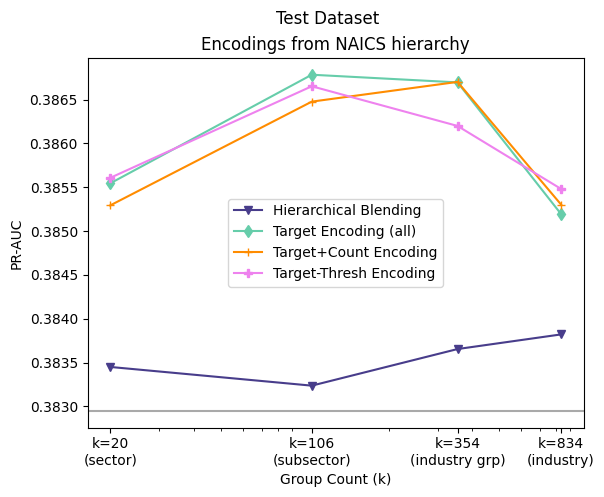

In [26]:
fig, ax = plt.subplots()
metrics_base_sum[metrics_base_sum['dset_naics_holdout'] == 0] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label=setup.model_label_dict['mhier'],color='darkslateblue', style='v-')
metrics_sum[metrics_sum['dset_naics_holdout'] == 0] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label=setup.model_label_dict['menc_all'],color='mediumaquamarine', style='d-')
metrics_tc_sum[metrics_tc_sum['dset_naics_holdout'] == 0] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label=setup.model_label_dict['tc'],color='darkorange', style='+-')
metrics_tt_sum[metrics_tt_sum['dset_naics_holdout'] == 0] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label=setup.model_label_dict['tt'],color='violet', style='P-')

ax.set_ylabel('PR-AUC')
ax.set_xlabel('Group Count (k)')
fig.suptitle('Test Dataset')
ax.set_title('Encodings from NAICS hierarchy')
plt.axhline(y=hline_test, color='darkgray')
ax.set_xticks(label_k)
ax.set_xticklabels(labels)
fig.savefig(Path(setup.temp_path).joinpath('A32_PLOT_compare_base_reg.png'),
            bbox_inches='tight')

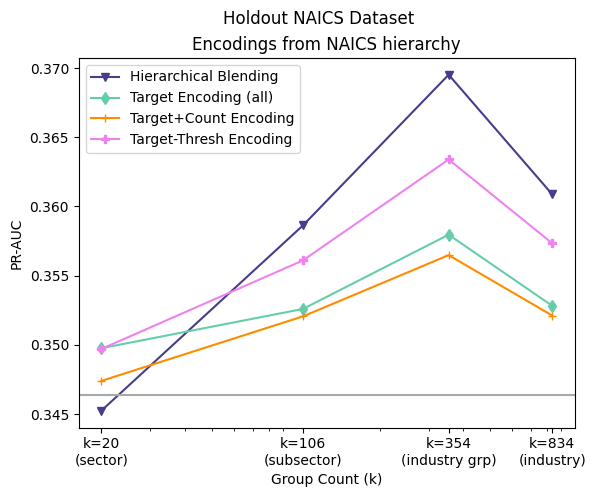

In [27]:
fig, ax = plt.subplots()
metrics_base_sum[metrics_base_sum['dset_naics_holdout'] == 1] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label=setup.model_label_dict['mhier'],color='darkslateblue', style='v-')
metrics_sum[metrics_sum['dset_naics_holdout'] == 1] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label=setup.model_label_dict['menc_all'],color='mediumaquamarine', style='d-')
metrics_tc_sum[metrics_tc_sum['dset_naics_holdout'] == 1] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label=setup.model_label_dict['tc'],color='darkorange', style='+-')
metrics_tt_sum[metrics_tt_sum['dset_naics_holdout'] == 1] \
    .plot(x='k', y='average_precision_score', logx=True, ax=ax, 
          label=setup.model_label_dict['tt'],color='violet', style='P-')
ax.set_ylabel('PR-AUC')
ax.set_xlabel('Group Count (k)')
fig.suptitle('Holdout NAICS Dataset')
ax.set_title('Encodings from NAICS hierarchy')
plt.axhline(y=hline_ho, color='darkgray')
ax.set_xticks(label_k)
ax.set_xticklabels(labels)
fig.savefig(Path(setup.temp_path).joinpath('A32_PLOT_compare_base_ho.png'),
            bbox_inches='tight')